# Convert "Standard" ONNX Resnet50 to CoreML
Load an off-the-shelf Resnet50 model for ONNX from [ONNX Model Zoo](https://github.com/onnx/models),  then convert to CoreML, sanity checking the work as we go.

Here's what happens in this notebook:
- Notebook Setup
- ONNX - Load and Validate Model
- O2C - Convert ONNX to CoreML and Validate
- Predictions - generate predictions from both models
- Agreement - briefly compare prediction agreement
- Show selected results

See [10-Intro-resnet50-convert-compare](10-Intro-resnet50-convert-compare.ipynb) for the context of this notebook, and a summary of results.

This notebook does not do any examination or editing of CoreML models. See the notebook [20-convert-torch-to-coreml](20-convert-torch-to-corem.ipynb) for examples of examination and editing.

The cell below is common setup for this and other notebooks. You do have to run it, but you can ignore it otherwise.

In [1]:
# Notebook setup (initially %load(ed) from 'notebook_setup.py')

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# mcs utilities and helpers
from ms_util import *

#Project Setup - Names & Commonly Used Values
project_name   = 'compare'   # Used as prefix for several derived names below
model_name     = 'resnet50'
model_arch     = 'Resnet50'   # Resnet50 , Resnet34, etc ...
img_size       = 300
batch_size     = 32

# %run -i {user_lib}/finish_setup.py [--show [Proj Paths Env] | None | All ] 
#
%run -i {user_lib}/finish_setup.py --show proj

data_root       =  /Volumes/ArielD/storage
data_dir        =  /Volumes/ArielD/storage/data
proj_data_dir   =  /Volumes/ArielD/storage/data/compare
project_name    =  compare
proj_data_dir   =  /Volumes/ArielD/storage/data/compare
proj_dir        =  /Users/mcsieber/storage/notebooks/compare
model_name      =  resnet50
model_arch      =  Resnet50
models_dir      =  /Volumes/ArielD/storage/data/compare/models
img_size        =  300
batch_size      =  32



## Additional Setup

In [2]:
from PIL import Image
from PIL import ImageOps
from coreml_help import *
from pred_help import *
mlmodels_dir = data_dir/'mlmodels'
resize_method = Image.NEAREST

#### Test Data - Get and Prepare test images

In [3]:
test_root     = data_root/'data'
test_data_dir = data_dir/'test'
imagenet_dir  = data_dir/'imagenet'
imagenet_path = imagenet_dir/'img_net_labels.txt'

In [4]:
dogcat_dir    = test_root/'dogscats/large/valid-large'
flowers_dir   = test_root/'flowers/data'
fruit_dir     = test_root/'food_poc/data'
food_dir      = Path('/Volumes/ArielD/storage/data/food/images')
pp((dogcat_dir, flowers_dir, food_dir,fruit_dir))

dogcat_dir     =  PosixPath('/Volumes/ArielD/storage/data/dogscats/large/valid-large')
flowers_dir    =  PosixPath('/Volumes/ArielD/storage/data/flowers/data')
food_dir       =  PosixPath('/Volumes/ArielD/storage/data/food/images')
fruit_dir      =  PosixPath('/Volumes/ArielD/storage/data/food_poc/data')


Get random images from various test image sets

In [6]:
ni  = 10           # Get this many images per directory
max_sample = 400  # Max sample range (set limit in case it is a huge directory)
#
t0 = get_rand_images(food_dir,   n_images=int(ni*3), search_limit=max_sample)
t1 = get_rand_images(dogcat_dir, n_images=ni, search_limit=max_sample)
t2 = get_rand_images(flowers_dir,n_images=ni, search_limit=max_sample)
t3 = get_rand_images(fruit_dir,   n_images=ni, search_limit=max_sample)
test_imgs = t0+t1+t2+t3
#
f"{len(test_imgs)} test images"

'43 test images'

Get validation images to sanity check the models as we create or convert them

In [7]:
validation_imgs = [
    Path('/Volumes/ArielD/storage/data/food_poc/data/apples/apple_029.jpg'),
    Path('/Volumes/ArielD/storage/data/compare/data/bana/bana_000.jpg'), ]

#### ImageNet - Read in Labels
These are the [1000 class labels](https://s3.amazonaws.com/onnx-model-zoo/synset.txt) for ImageNet. 

In [8]:
with open(imagenet_path, 'r') as list_ : 
    inet_labels = [line.rstrip() for line in list_ ]
f"{len(inet_labels)} imagenet labels"

'1000 imagenet labels'

#### ImageNet - Calculate Scale and Bias for ONNX and CoreML models
As recommended, input images for the ONNX model are normalized
using the mean and standard deviation for **ImageNet**.
(For details, see Help or Notes for `imagenet_normalize`):

For the CoreML models, we use the values above to calculate an *image scale*
and (Red, Green, Blue) *channel biases* that acheive (almost) the same effect.

In [9]:
# Values for ONNX ImageNet normalization
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

# For CoreML from ONNX, calculate scale and bias to reproduce normalization
ppargs = dict(
    image_scale= 1/(255.0*std.mean()),
    red_bias   = - mean[0]/std[0],
    green_bias = - mean[1]/std[1],
    blue_bias  = - mean[2]/std[2]
)
ppargs

{'image_scale': 0.01735207357279195,
 'red_bias': -2.1179039301310043,
 'green_bias': -2.0357142857142856,
 'blue_bias': -1.8044444444444445}

## ONNX
ONNX - These cells load and check the [ONNX Resnet50(v2)](https://s3.amazonaws.com/onnx-model-zoo/resnet/resnet50v2/resnet50v2.tar.gz) model. This was downloaded from the [ONNX Model Zoo](https://github.com/onnx/models)

In [10]:
import onnx
import onnxruntime as ort
from onnx_coreml import convert
from coremltools import models as cm

In [11]:
onnxm_name   = 'resnet50.onnx'
onnxm_path   = data_dir/'onnx/resnet50v2'/onnxm_name ; onnxm_path

PosixPath('/Volumes/ArielD/storage/data/onnx/resnet50v2/resnet50.onnx')

In [12]:
onnxm = onnx.load(onnxm_path)
onnx.checker.check_model(onnxm)

#### ONNX Quick Check
Use the model to identify a couple of images that *should* be easily identifiable.  If the model does not categorize these correctly, there is a error of some sort in the setup or downloaded images or downloaded model.

In [13]:
onnx_rt  = ort.InferenceSession(onnxm_path.as_posix())

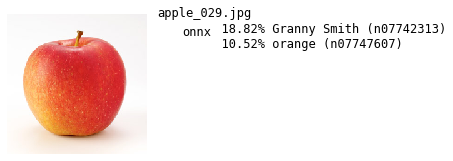

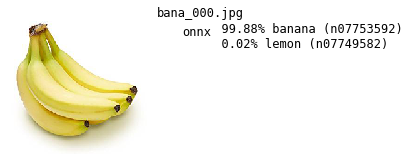

In [14]:
for img_path in validation_imgs:
    pred = pred_for_onnx(onnx_rt,Image.open(img_path),labels=inet_labels)
    if  show_pred(img_path,pred,model_id='onnx') is None: break

### ONNX -> CoreML
O2C - These cells convert the "standard" ONNX Resnet Model from above to a CoreML Model.

In [15]:
o2c_name = 'o2c.mlmodel'
o2c_path = models_dir/o2c_name # This is the CoreML 'spec' path, *NOT* the 'mlmodelc' path
o2c_path

PosixPath('/Volumes/ArielD/storage/data/compare/models/o2c.mlmodel')

In [16]:
o2c = convert( onnxm,
               image_input_names=['data'],
               preprocessing_args=ppargs );

1/174: Converting Node Type BatchNormalization
2/174: Converting Node Type Conv
3/174: Converting Node Type BatchNormalization
4/174: Converting Node Type Relu
5/174: Converting Node Type MaxPool
6/174: Converting Node Type BatchNormalization
7/174: Converting Node Type Relu
8/174: Converting Node Type Conv
9/174: Converting Node Type BatchNormalization
10/174: Converting Node Type Relu
11/174: Converting Node Type Conv
12/174: Converting Node Type BatchNormalization
13/174: Converting Node Type Relu
14/174: Converting Node Type Conv
15/174: Converting Node Type Conv
16/174: Converting Node Type Add
17/174: Converting Node Type BatchNormalization
18/174: Converting Node Type Relu
19/174: Converting Node Type Conv
20/174: Converting Node Type BatchNormalization
21/174: Converting Node Type Relu
22/174: Converting Node Type Conv
23/174: Converting Node Type BatchNormalization
24/174: Converting Node Type Relu
25/174: Converting Node Type Conv
26/174: Converting Node Type Add
27/174: Conv

In [17]:
o2c.save(o2c_path.as_posix())

#### O2C Quick Check
As before, sanity check the model on something easy and obvious

In [18]:
o2c  = cm.MLModel(o2c_path.as_posix())

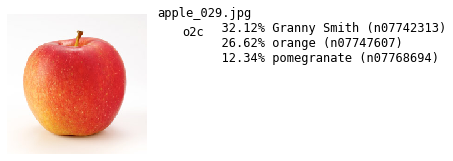

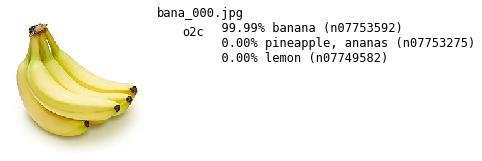

In [19]:
for img_path in validation_imgs:
    img = ImageOps.fit(Image.open(img_path),(224,224), method=resize_method, centering=(0.5,0.4))
    pred = pred_for_o2c(o2c,img,labels=inet_labels)
    if show_pred(img_path, pred, n_2show=3, model_id='o2c') is None: break

#### A Note on CoreML naming: 

*"mlmodel"* can be a confusing reference if you are just learning about CoreML.
- The `.mlmodel` *file* is the *protobuf* *spec* for the CoreML model. The name and path above refer to this file. When the *spec* file is loaded into Python, it has a type of `Model_pb2.Model`.
- In Python code,  "MLModel" refers to the `MLModel` Class or an object with this class (ie. the "CoreML model"), *not* the spec.
- When a CoreML model is created (compiled), the model is written to a directory suffixed by `.mlmodelc`


For example, for the model above:

In [20]:
type(o2c)

coremltools.models.model.MLModel

In [21]:
 type(o2c.get_spec())

Model_pb2.Model

When you see a variable with "mlmodel" in the name, it might be referring to the spec, or it might be referring to the CoreML model (the MLModel Class object). You have to check.

## Predictions - Compare Original and Converted Models

In [22]:
import matplotlib.pyplot as plt
from pred_help import *
import numpy as np

### Setup

This code uses three lists to gather results:
- **results** - Records the prediction results for each model for each image.
- **top_prob** - ndarray containing `top_num` probabilities for each prediction. Order is: *model #, image #, probs*
- **top_classes** - ndarray containing `top_num` classes (indexes for each prediction). Order is: *model #, image #, probs*


It creates a *"result template"* to specify the models and model short names we are going to use. Use that to generate *model short names* <--> *number mappings*. Create and allocate the arrays in which to gather result information

Specify the models to be included in the results, and set the number of predictions to return, and the number of predictions to show

In [23]:
result_template = { 'name' : '', 'path' : None,
    'onnx' : pred_for_onnx,
    'o2c'  : pred_for_o2c,
    # additional models would go here
}
num_top     = 3  # Number of top prediction items (classes, probs, labels) to return (3 is default)
num_to_show = 3  # Number of probabilities to show for each prediction.

Generate parameters for code cells below

In [24]:
num_imgs  = len(test_imgs)  # Number of images
rep_every = int(num_imgs/5) # Interval for progress reports
model_list = [k for k in result_template if k not in ['name','path']]
num_models = len(model_list)
i2m        = model_list # synonym; model index --> model name
m2i        = {m:i for i,m in enumerate(model_list)}  # model name --> model index
model_list

['onnx', 'o2c']

Allocate arrays

In [25]:
probs_per_model    = [ [0.0]*num_top ]*num_imgs
classidx_per_model = [   [0]*num_top ]*num_imgs
#
top_prob    = np.array( [probs_per_model   ] * num_models )
top_classes = np.array( [classidx_per_model] * num_models )
results     = [result_template] * num_imgs
#
tp = top_prob # Synonym
tc = top_classes #Synonym

### Predictions
Make predictions on the test images using each model and save the results

(NOTE: The 'res' dictionary below must correspond to the "result_template" above)

In [26]:
def pred_results(path):
    name   = Path(path).name
    img    = Image.open(path)
    if img.mode != 'RGB':
        print(f'Attempting to convert {name} from {img.mode} to RGB')
        img = img.convert('RGB')
    img300 = ImageOps.fit(img,(300,300), method=resize_method, centering=(0.5,0.4))
    img224 = ImageOps.fit(img,(224,224), method=resize_method, centering=(0.5,0.4))
    res = {'name' : name, 'path' : path.as_posix(),
        'onnx' : pred_for_onnx(onnx_rt,img300, labels=inet_labels),
        'o2c'  : pred_for_o2c(o2c,img224,labels=inet_labels),
     }
    return res

In [27]:
for i, path in enumerate(test_imgs):
    results[i] = pred_results(path)
    if (i%rep_every)== 0 : print(f"{i} of {num_imgs} images processed, most recent is {path.name} ")

    # Capture copies of class indexes and probabilities and 
    # save in numpy arrays by model for later calculation
    for model in model_list: 
        mi     = m2i[model]
        model_result = results[i][model]
        top_classes[mi][i] = np.array(model_result.topI)
        top_prob[mi][i]    = np.array(model_result.topP)
        
print(f"Total of {i+1} images processed")


0 of 43 images processed, most recent is roots_073.jpg 
Attempting to convert chick_199.png from RGBA to RGB
8 of 43 images processed, most recent is chick_199.png 
16 of 43 images processed, most recent is burger_141.jpg 
24 of 43 images processed, most recent is cat.4646.jpg 
32 of 43 images processed, most recent is 13923036338_1ce32c6d4f.jpg 
40 of 43 images processed, most recent is apple_096.jpg 
Total of 43 images processed


### Agreement?
How often do the original model and the converted model agree on the top prediction?

In [28]:
ONNX = m2i['onnx']   # Model abbr to Model # (index)
O2C  = m2i['o2c']    # Module # to Model abbr

Create boolen arrays to tabulate those images for which the top classes agree and disagree

In [31]:
pred_agree    = tc[ONNX,:,0] == tc[O2C,:,0]
pa = pred_agree

In [32]:
f"ONNX agrees with O2C {pa.sum()} out of {pa.size} images, or {pa.sum()/pa.size:2.2%}" 

'ONNX agrees with O2C 30 out of 43 images, or 69.77%'

`show_result` - a helpful routine for the next section

In [34]:
def show_result(result,n2show=num_to_show):
    img_path = result["path"]
    model_list = [k for k in result if k not in ['name','path']]
    m1 = model_list.pop(0)
    axs, x, y = show_pred(img_path, result[m1], model_id=m1,n_2show=n2show,fig_size=(3.0,4.0), immediate=False )
    for m in model_list:
        x, y = add_pred(axs,x,y,result[m],model_id=m, n_2show=n2show )
    plt.show()

## Show Results 
Show a selection of the results

In [35]:
results_to_show = 8
probs_to_show = 2

In [36]:
import random


Showing results [4, 6, 14, 29, 31, 33, 40, 42] 
  and top 2 probablities for each model


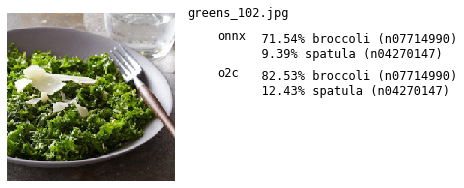

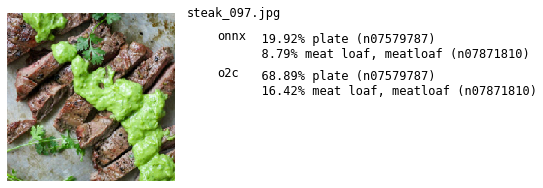

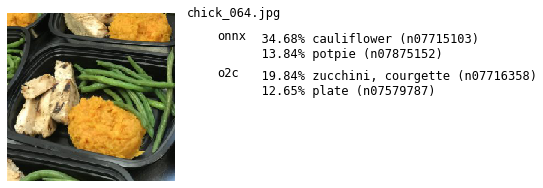

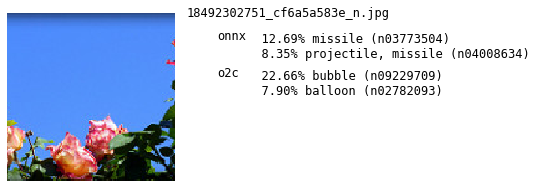

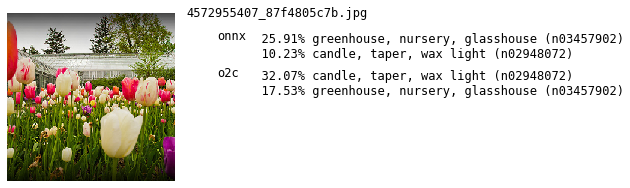

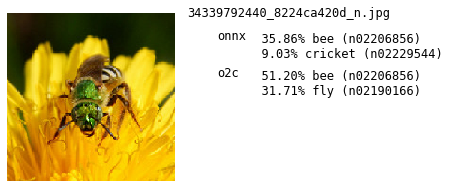

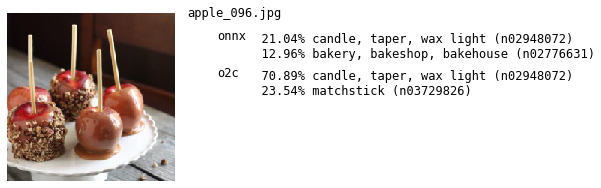

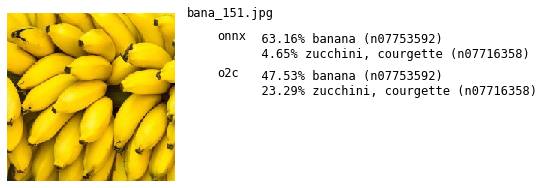

In [37]:
display_list = random.sample(range(len(results)), results_to_show)
display_list.sort()
print(f"\nShowing results {display_list} \n  and top {probs_to_show} probablities for each model")
for i in display_list: show_result(results[i],n2show=probs_to_show)